In [78]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

***
# 2017 NSCH Data

**Code book:** https://www.census.gov/data-tools/demo/nsch/#/?s_searchvalue=age&s_year=2017&selectedVar=A1_AGE

**Article:** http://time.com/5437607/smartphones-teens-mental-health/


In [79]:
df = pd.read_stata('nsch_2017_topical.dta')
df.head()

,fipsst,stratum,hhid,formtype,totkids_r,hhlanguage,sc_age_years,sc_sex,k2q35a_1_years,momage,...,a1_grade_if,bmiclass,hhcount_if,fpl_i1,fpl_i2,fpl_i3,fpl_i4,fpl_i5,fpl_i6,fwc
0,37,1,17000010,T1,3,3.0,0,2,NaN,36.0,...,0,NaN,0,50,50,50,50,50,50,16407.556854
1,2,2A,17000013,T3,1,1.0,13,2,NaN,30.0,...,0,2.0,0,181,181,181,181,181,181,152.449899
2,40,1,17000025,T3,1,1.0,15,1,13.0,30.0,...,0,2.0,0,329,329,329,329,329,329,605.780083
3,13,1,17000031,T2,1,1.0,9,1,NaN,27.0,...,0,NaN,0,347,347,347,347,347,347,1793.169449
4,31,1,17000034,T2,2,1.0,8,2,NaN,27.0,...,0,NaN,0,400,400,400,400,400,400,688.982814


## Cleaning variables

`sc_age_years`: Age of Selected Child - In Years (0 - 17)

In [80]:
df.sc_age_years.describe()

count    21599.000000
mean         9.428585
std          5.260100
min          0.000000
25%          5.000000
50%         10.000000
75%         14.000000
max         17.000000
Name: sc_age_years, dtype: float64

***

`k7q91_r`: How Much Time Spent with Computers

`k7q60_r`: How Much Time Spent Watching TV

**Response Codes:**
- 1 = None
- 2 = Less than 1 hour
- 3 = 1 hour
- 4 = 2 hours
- 5 = 3 hours
- 6 = 4 or more hours

In [81]:
df['cmputr_time'] = df.k7q91_r.copy() - 1
df.cmputr_time.describe()

count    21402.000000
mean         2.279507
std          1.555088
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: cmputr_time, dtype: float64

In [82]:
df['tv_time'] = df.k7q60_r.copy() - 1
df.tv_time.describe()

count    21399.000000
mean         2.314547
std          1.321909
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: tv_time, dtype: float64

***
`k4q22_r`: DURING THE PAST 12 MONTHS, has (fill with SC_NAME) received any treatment or counseling from a mental health professional...Mental health professionals include psychiatrists, psychologists, psychiatric nurses, and clinical social workers.

**Response Code:**
- 1 = Yes
- 2 = No, but this child needed to see a mental health professional
- 3 = No, this child did not need to see a mental health professional

In [83]:
df['need_treatment'] = df.k4q22_r.dropna().copy()
df.need_treatment.describe()

count    21504.000000
mean         2.773484
std          0.619546
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: need_treatment, dtype: float64

***
`k2q33c`: Anxiety Severity Level.

**Response Code:**
- NaN = Does not have this condition currently (will be replaced with 0)
- 1 = Mild
- 2 = Moderate
- 3 = Severe

In [84]:
df['anxiety_lvl'] = df.k2q33c.fillna(0).copy()
df['anxiety_lvl'].describe()

count    21599.000000
mean         0.131534
std          0.479476
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: anxiety_lvl, dtype: float64

***
`k2q32c`: Depression Severity Level.

**Response Code:**
- NaN = Does not have this condition currently (will be replaced with 0)
- 1 = Mild
- 2 = Moderate
- 3 = Severe

In [85]:
df['depression_lvl'] = df.k2q32c.fillna(0).copy()
df['depression_lvl'].describe()

count    21599.000000
mean         0.056484
std          0.316761
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: depression_lvl, dtype: float64

***
`k7q83_r`: How well do each of the following phrases describe: Your child does all required homework

**Response Code:**
- 1 = Definitely true
- 2 = Somewhat true
- 3 = Not true

In [132]:
df['homework_completion'] = df.k7q83_r.dropna().copy()
df.homework_completion.describe()

count    15238.000000
mean         1.305027
std          0.550181
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: homework_completion, dtype: float64

***
`k8q11`: DURING THE PAST WEEK, on how many days did all the family members who live in the household eat a meal together?

**Response Code:**
- 1 = 0 days
- 2 = 1-3 days
- 3 = 4-6 days
- 4 = Every day

In [137]:
df['family_meals'] = df.k8q11.dropna().copy()
df.family_meals.describe()

count    21278.000000
mean         3.065232
std          0.866397
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: family_meals, dtype: float64

***
## Experiments with these variables

### Plot age vs Screen time
Variables used: `sc_age_years`, `cmputr_time`, `tv_time`

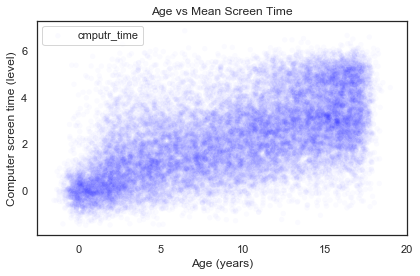

In [86]:
# Jitter plot
x = thinkstats2.Jitter(df.sc_age_years, 0.5)
y1 = thinkstats2.Jitter(df.cmputr_time, 0.5)
thinkplot.Scatter(x, y1, alpha=0.02)
plt.legend(loc='best')
decorate(title='Age vs Mean Screen Time', xlabel='Age (years)', ylabel='Computer screen time (level)')

In [87]:
# Group them into age year bins
bins = np.arange(df.sc_age_years.min(), df.sc_age_years.max() + 1, 1)
indices = np.digitize(df.sc_age_years, bins)
groups = df.groupby(indices)

cmputr_time = [group.cmputr_time.mean() for i, group in groups]
tv_time = [group.tv_time.mean() for i, group in groups]
total_time = [group.cmputr_time.mean() + group.tv_time.mean() for i, group in groups]

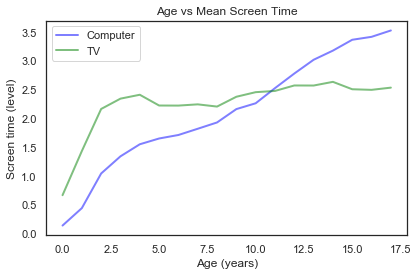

In [88]:
plt.plot(bins, cmputr_time, label='Computer', linewidth=2, color='blue', alpha=0.5)
plt.plot(bins, tv_time, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Age vs Mean Screen Time', xlabel='Age (years)', ylabel='Screen time (level)')

***
### Screen time vs Need treament
Variables used: `cmputr_time`, `tv_time`, `need_treatment`

In [89]:
# Group them into bins
def group_to_bins(df, group_name, variable):
    dataSeries = df[group_name]
    bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
    indices = np.digitize(dataSeries, bins)
    groups = df.groupby(indices)

    perc_1 = []
    perc_2 = []
    for i, group in groups:
        count = count_2 = 0
        total = group[variable].count()
        for value in group[variable]:
            if (value == 1):
                count += 1
            if (value == 2):
                count_2 += 1
        perc_1.append(count/total*100)
        perc_2.append((count + count_2)/total*100)
    return bins, perc_1, perc_2

bins, perc_1, perc_2 = group_to_bins(df, 'cmputr_time', 'need_treatment')
bins_tv, perc_1_tv, perc_2_tv = group_to_bins(df, 'tv_time', 'need_treatment')

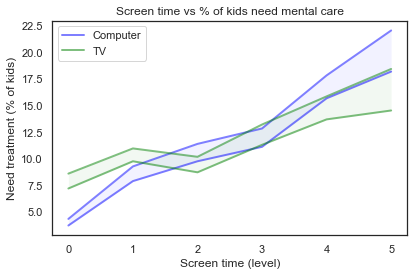

In [90]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc_1, label='Computer', linewidth=2, color='blue', alpha=0.5)
ax.plot(bins, perc_2, linewidth=2, color='blue', alpha=0.5)
ax.fill_between(bins, perc_1, perc_2, where=perc_2 >= perc_1, facecolor='blue', alpha=0.05, interpolate=True)
# TV time
ax.plot(bins_tv, perc_1_tv, label='TV', linewidth=2, color='green', alpha=0.5)
ax.plot(bins_tv, perc_2_tv, linewidth=2, color='green', alpha=0.5)
ax.fill_between(bins_tv, perc_1_tv, perc_2_tv, where=perc_2_tv >= perc_1_tv, facecolor='green', alpha=0.05, interpolate=True)
plt.legend(loc='best')
decorate(title='Screen time vs % of kids need mental care', xlabel='Screen time (level)', ylabel='Need treatment (% of kids)')

***
### Screen time vs Anxiety level
Variables used: `cmputr_time`, `tv_time`, `anxiety_lvl`

In [124]:
# Group them into bins
def group_to_bins(df, group_name, variable):
    dataSeries = df[group_name]
    bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
    indices = np.digitize(dataSeries, bins)
    groups = df.groupby(indices)

    perc = []
    for i, group in groups:
        perc.append(group[variable].mean())
    return bins, perc

bins, perc = group_to_bins(df, 'cmputr_time', 'anxiety_lvl')
bins_tv, perc_tv = group_to_bins(df, 'tv_time', 'anxiety_lvl')

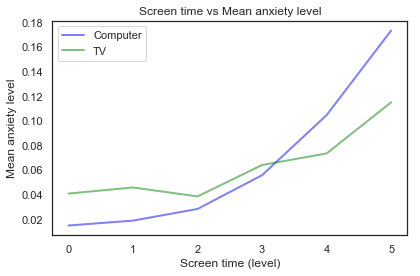

In [122]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
# TV time
ax.plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Screen time vs Mean anxiety level', xlabel='Screen time (level)', ylabel='Mean anxiety level')

***
### Screen time vs Depression level
Variables used: `cmputr_time`, `tv_time`, `depression_lvl`

In [118]:
# Group them into bins
bins, perc = group_to_bins(df, 'cmputr_time', 'depression_lvl')
bins_tv, perc_tv = group_to_bins(df, 'tv_time', 'depression_lvl')

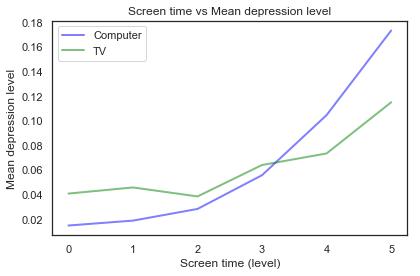

In [121]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
# TV time
ax.plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Screen time vs Mean depression level', xlabel='Screen time (level)', ylabel='Mean depression level')

***
### Screen time vs Homework completion
Variables used: `cmputr_time`, `tv_time`, `homework_completion`

In [133]:
# Group them into bins
bins, perc = group_to_bins(df, 'cmputr_time', 'homework_completion')
bins_tv, perc_tv = group_to_bins(df, 'tv_time', 'homework_completion')

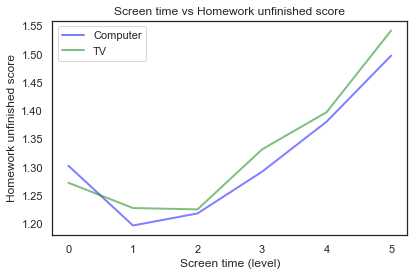

In [135]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc, label='Computer', linewidth=2, color='blue', alpha=0.5)
# TV time
ax.plot(bins_tv, perc_tv, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Screen time vs Homework unfinished score', xlabel='Screen time (level)', ylabel='Homework unfinished score')

***
### Family meals vs Anxiety/Depression level
Variables used: `family_meals`, `anxiety_lvl`

In [146]:
# Group them into age year bins
bins, perc = group_to_bins(df, 'family_meals', 'anxiety_lvl')
bins_depress, perc_depress = group_to_bins(df, 'family_meals', 'depression_lvl')

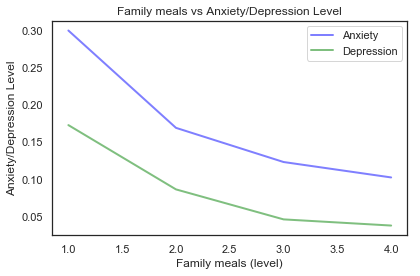

In [148]:
fig, ax = plt.subplots()
# Depression level
ax.plot(bins, perc, label='Anxiety', linewidth=2, color='blue', alpha=0.5)
ax.plot(bins_depress, perc_depress, label='Depression', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Family meals vs Anxiety/Depression Level', xlabel='Family meals (level)', ylabel='Anxiety/Depression Level')